In [13]:
require(tidyverse)
require(ggplot2)
require(data.table)
require(FlowSOM)
require(viridis)
require(nationalparkcolors)
require(pheatmap)
require(uwot)
require(RSpectra)
require(viridis)
require(calecopal)
require(PNWColors)
require(corrplot)
require(reshape2)
require(ggbeeswarm)
require(ggrepel)
require(ggsignif)
require(UpSetR)
require(ggpubr)
library(BuenColors)
require(magrittr)
source('Marla_function.r')

In [2]:
###### USER INPUTS ######

images.path <- ""
dat.path <- "/home/jupyter/BRI_Figures_Final_V2/Dataset/B_cell_clustered_flow/IHA_01089_PBMC_flow_bcell_clustered_dat.csv"
path <- ""

factors <- c("cell_type", "donor", "timepoint", "group", "isotype", "cluster", "meta", "non_B")

donors <- c("BR1025","BR1031","BR1032","BR1047","BR1050","BR1057",
            "BR2013","BR2021","BR2023","BR2039","BR2044","BR2051")

times <- c("day0", "day7", "day90")
time.colors <- c("#3E5641", "#A84D38", "#DE8A68") %>% setNames(times) 

groups <- c("BR1", "BR2")
group.colors <- c("#C8E8C4", "#34236E") %>% setNames(groups) 

active.factors <- c("CD69_pos", "CXCR3_pos")
active.colors <- pnw_palette("Bay", 2) %>% as.vector() %>% setNames(active.factors)

all.cols <- c("CD183", "CD69",	"Lin", "CD19", "CD45RB", "CD24", "CD20", "HLA_DR",	"CD27",	"CD10",	
              "CD21", "CD73", "CD95", "CD11c", "CD23", "CD32", "CD38",
              "IgG", "IgA", "IgD", "IgM")

surface.markers <- c("CD183", "CD69",	"Lin", "CD19", "CD45RB",	"CD24", "CD20",	"HLA_DR",	"CD27",	"CD10",	
                     "CD21", "CD73", "CD95", "CD11c", "CD23", "CD32", "CD38",
                     "IgG", "IgA", "IgD", "IgM")

pal <- cal_palette(name="lupinus", n=6, type="continuous")
pal2 <- cal_palette(name="canary", n=6, type="continuous")
donor.colors <- c(pal, pal2) %>% setNames(donors)

subsets.orig <- c("CD11c_Effector", "Early_Memory", "Core_Memory", "CD95_Memory", "T2MBC",
             "Transitional", "Naive", 
             "Plasma")
subsets <- c("CD27_neg_Effector", "CD27_pos_Effector", "Early_Memory", "Core_Memory", "CD95_Memory", "T2MBC",
             "Transitional", "Naive", 
             "Plasma")
subset.colors <- c("#F9B5AC", "#861D31", "#C4E2E1", "#338481", "#263FA6", "#02F2BE", "#805D93", "#CF7C63", "#323949") %>% setNames(subsets)

isotypes <- c("IgD", "IgMD", "IgM", "IgG", "IgA", "ND", "surface_Ig-")
isotype.colors <- c("#664A5B", "#C05746", "#4D7184", "#8DB979", "#012A36", "#D1D2D4", "#ED7D3B") %>% setNames(isotypes)
isotype.channels <- isotypes[c(1, 3, 4, 5)]

In [3]:
# upload data
dat <- fread(dat.path) %>%
  as.data.table() %>%
  .[non_B==T, meta:="NA"] %>% 
  .[meta=="RBposCD27neg_Early_Memory", meta:="Early_Memory"] %>%
  .[meta=="RBposCD27pos_Memory", meta:="Core_Memory"] %>% 
  .[, `:=`(donor=factor(donor, levels=donors),
           cell_type=factor(cell_type), 
           timepoint=factor(timepoint, levels=times), 
           group=factor(group, levels=groups),
           isotype=factor(isotype, levels=isotypes), 
           meta=factor(meta, levels=subsets.orig))] %>%
  setCutoffsMarkers() %>% 
  .[, `:=`(donor=factor(donor, levels=donors),
           cell_type=factor(cell_type), 
           timepoint=factor(timepoint, levels=times), 
           group=factor(group, levels=groups),
           isotype=factor(isotype, levels=isotypes), 
           meta=factor(meta, levels=subsets.orig))] %>% 
  .[meta=="CD11c_Effector" & CD27_pos==F, meta:="CD27_neg_Effector"] %>%
  .[meta=="CD11c_Effector" & CD27_pos==T, meta:="CD27_pos_Effector"] %>% 
  .[, `:=`(donor=factor(donor, levels=donors),
           cell_type=factor(cell_type), 
           timepoint=factor(timepoint, levels=times), 
           group=factor(group, levels=groups),
           isotype=factor(isotype, levels=isotypes), 
           meta=factor(meta, levels=subsets))]


[1] "Setting cutoffs CXCR3+ B cells"


Warning message:
“Removed 765 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 765 rows containing missing values or values outside the scale range
(`geom_point()`).”


[1] "Setting cutoffs CD69+ B cells"


Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_point()`).”


[1] "Setting cutoffs CD27+ B cells"


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message in grid.Call.graphics(C_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


In [4]:
isotypeBCellPlots <- function(dt, 
                        ic=isotype.colors, 
                        pa=images.path) {
  # Generates stacked bar graph with percentages of B cell isotype and Ig biaxial plots
  # Inputs:
  #   dt - data.table of data
  #   ic - named vector of isotype colors
  #   pa - path to images folder
  # Outputs:
  #   eps of stacked bar plot with freq of B cell isotypes by timepoint and Ig biaxial plots
  # stacked bar plot with heavy chain isotype composition of all B cells by age group
  temp <- dt[, .N, by=.(isotype, group, timepoint)] %>% 
    .[, P:=N*100/sum(N), by=.(group, timepoint)] %>%
    .[, isotype:=factor(isotype, levels=isotypes)] %>% 
    .[, timepoint:=factor(timepoint, levels=times)]
  ggplot(temp, aes(timepoint, P, fill=isotype)) + 
    geom_col(width=0.9, color="black", position="fill") + 
    facet_grid(~group) + 
    theme_minimal() +
    ylab("Percent of B cells (%)") +
    xlab(" ") +
    labs(fill="Isotype") +
    scale_fill_manual(values=ic) +
    theme(text=element_text(size=25), 
          axis.text.x=element_text(angle=270, size=20), 
          legend.position='right')
  ggsave(paste0(pa, "Stack_b_isotype.eps"), width=8, height=8)
  ggsave(paste0(pa, "Stack_b_isotype.png"), width=8, height=8)
  #Ig biaxial plots
  iso.perc.eff <- dt[meta=="CD27_neg_Effector", .N, by=.(isotype, group, timepoint)] %>% 
    .[, P:=N*100/sum(N), by=.(group, timepoint)] %>%
    .[timepoint=="day7"] %>% 
    .[, isotype:=factor(isotype, levels=isotypes)] %>% 
    .[, timepoint:=factor(timepoint, levels=times)]
  markers <- c("IgG", "IgM", "IgD", "IgA")
  cutoffs <- c(0.75, 0.62, 0.61, 0.8)
  names(cutoffs) <- markers
 
  n.sample <- 2000
  set.seed(888)
  sub <- dt[meta=="CD27_neg_Effector" & timepoint=="day7", .SD[sample(.N, n.sample)], by=.(group)] %>% 
    as.data.table() %>%
    .[, timepoint:=factor(timepoint)] %>%
    .[, group:=factor(group, levels=groups)]
  for (mar in markers) {
    sub$density <- get_density(sub[, eval(parse(text=mar))], sub$CD19, n=100)
    ggplot(sub[group=="Young"], aes(eval(parse(text=mar)), CD19)) + 
      geom_density2d(color="#CCCCCC") +
      geom_point(aes(color=density), stroke=0, size=2) + 
      geom_text(aes(label=paste0(round(iso.perc.eff[group=="Young" & isotype==mar, P], digits=1), "%"), x=1.07, y=1.1), color='black', size=8) + 
      scale_color_viridis(option='magma', name="Density", direction=1) + 
      xlim(0.5, 1.1) +
      ylim(0.5, 1.1) +
      theme_minimal() + 
      geom_vline(xintercept=cutoffs[mar]) + 
      ggtitle("Day 7 \nCD27- Effector B cells \nYoung Adults") + 
      xlab(paste(mar, "expression")) +
      ylab("CD19 expression") +
      theme(text=element_text(size=30), 
            legend.position='right')
      ggsave(paste0(pa, mar, "_young_day7_CD27neg_EffectorB_biaxial.png"), width=8, height=6)
      ggplot(sub[group=="Older"], aes(eval(parse(text=mar)), CD19)) + 
        geom_density2d(color="#CCCCCC") +
        geom_point(aes(color=density), stroke=0, size=2) + 
        geom_text(aes(label=paste0(round(iso.perc.eff[group=="Older" & isotype==mar, P], digits=1), "%"), x=1.07, y=1.1), color='black', size=8) + 
        scale_color_viridis(option='magma', name="Density", direction=1) + 
        xlim(0.5, 1.1) +
        ylim(0.5, 1.1) +
        theme_minimal() + 
        geom_vline(xintercept=cutoffs[mar]) + 
        ggtitle("Day 7 \nCD27- Effector B cells \nOlder Adults") + 
        xlab(paste(mar, "expression")) +
        ylab("CD19 expression") +
        theme(text=element_text(size=30), 
              legend.position='right')
      ggsave(paste0(pa, mar, "_older_day7_CD27neg_EffectorB_biaxial.png"), width=8, height=6)
   }
}

In [18]:
df=as.data.frame(dat)

In [20]:
 #Ig biaxial plots
iso.perc.eff <- dat[meta=="CD27_neg_Effector", .N, by=.(isotype, group, timepoint)] %>% 
    .[, P:=N*100/sum(N), by=.(group, timepoint)] %>%
    .[timepoint=="day7"] %>% 
    .[, isotype:=factor(isotype, levels=isotypes)] %>% 
    .[, timepoint:=factor(timepoint, levels=times)]

In [54]:
write.csv(iso.perc.eff,"iso.perc.eff.csv")

In [22]:
markers <- c("IgG", "IgM", "IgD", "IgA")
cutoffs <- c(0.75, 0.62, 0.61, 0.8)
names(cutoffs) <- markers


sub <- dat[meta=="CD27_neg_Effector" & timepoint=="day7", .SD[sample(.N, n.sample)], by=.(group)] %>% 
as.data.table() %>%
.[, timepoint:=factor(timepoint)] %>%
.[, group:=factor(group, levels=groups)]

In [47]:
sub$density <- get_density(sub[, eval(parse(text='IgG'))], sub$CD19, n=100)


In [56]:
write.csv(sub,"density_data_CD27neg.csv")

Warning message in geom_text(aes(label = paste0(round(iso.perc.eff[group == "BR2" & :
“All aesthetics have length 1, but the data has 4000 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message:
“Removed 224 rows containing non-finite outside the scale range
(`stat_density2d()`).”
Warning message:
“Removed 224 rows containing missing values or values outside the scale range
(`geom_point()`).”


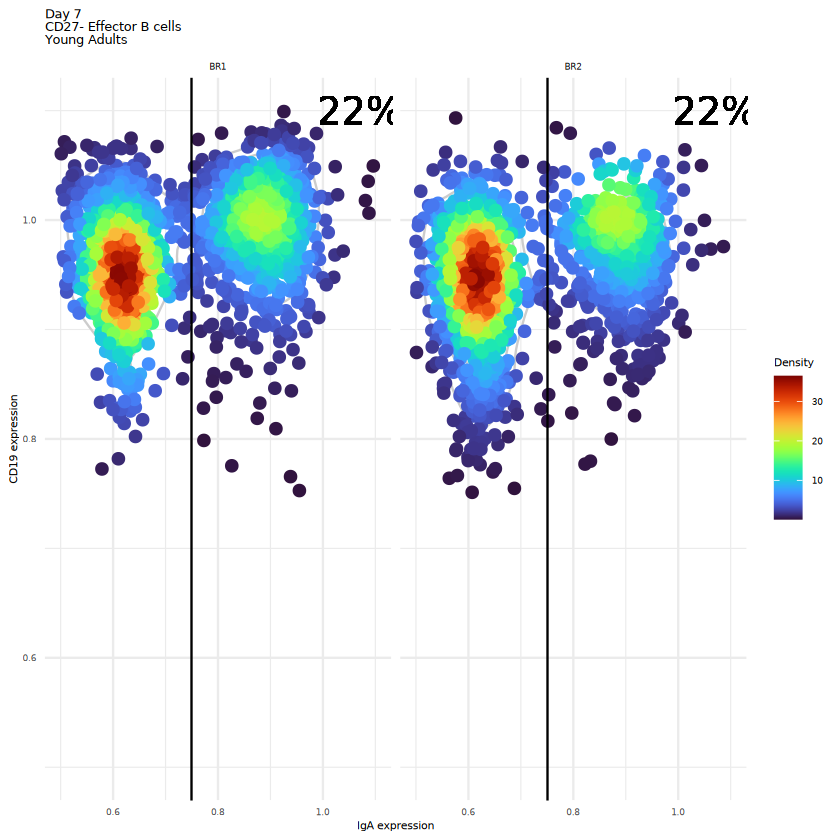

In [55]:
ggplot(as.data.frame(sub[group=="BR2"]), aes(x=IgG, y=CD19)) + 
  geom_density2d(color="#CCCCCC") +
  geom_point(aes(color=density), stroke=1, size=2) + 
  geom_text(aes(label=paste0(round(iso.perc.eff[group=="BR2" & isotype=='IgG', P], 
                                   digits=1), "%"), x=1.07, y=1.1), color='black', size=8) + 
  scale_color_viridis(option='H', name="Density", direction=1) + 
  xlim(0.5, 1.1) +
  ylim(0.5, 1.1) +
  theme_minimal() + 
  geom_vline(xintercept=0.75) + 
  ggtitle("Day 7 \nCD27- Effector B cells \nYoung Adults") + 
  xlab(paste(mar, "expression")) +
  ylab("CD19 expression") +
  theme(text=element_text(size=6), 
        legend.position='right')

In [26]:
 for (mar in markers) {
    sub$density <- get_density(sub[, eval(parse(text=mar))], sub$CD19, n=100)
    ggplot(sub[group=="Young"], aes(eval(parse(text=mar)), CD19)) + 
      geom_density2d(color="#CCCCCC") +
      geom_point(aes(color=density), stroke=0, size=2) + 
      geom_text(aes(label=paste0(round(iso.perc.eff[group=="Young" & isotype==mar, P], digits=1), "%"), x=1.07, y=1.1), color='black', size=8) + 
      scale_color_viridis(option='magma', name="Density", direction=1) + 
      xlim(0.5, 1.1) +
      ylim(0.5, 1.1) +
      theme_minimal() + 
      geom_vline(xintercept=cutoffs[mar]) + 
      ggtitle("Day 7 \nCD27- Effector B cells \nYoung Adults") + 
      xlab(paste(mar, "expression")) +
      ylab("CD19 expression") +
      theme(text=element_text(size=30), 
            legend.position='right')
    ggplot(sub[group=="Older"], aes(eval(parse(text=mar)), CD19)) + 
        geom_density2d(color="#CCCCCC") +
        geom_point(aes(color=density), stroke=0, size=2) + 
        geom_text(aes(label=paste0(round(iso.perc.eff[group=="Older" & isotype==mar, P], digits=1), "%"), x=1.07, y=1.1), color='black', size=8) + 
        scale_color_viridis(option='magma', name="Density", direction=1) + 
        xlim(0.5, 1.1) +
        ylim(0.5, 1.1) +
        theme_minimal() + 
        geom_vline(xintercept=cutoffs[mar]) + 
        ggtitle("Day 7 \nCD27- Effector B cells \nOlder Adults") + 
        xlab(paste(mar, "expression")) +
        ylab("CD19 expression") +
        theme(text=element_text(size=30), 
              legend.position='right')
   }